# Finetuning BERT with Keras and tf.Module

In [0]:
!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo

import re
import os
import sys
import json

import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from google.colab import auth, drive

if not 'bert_repo' in sys.path:
    sys.path.insert(0, 'bert_repo')

from modeling import BertModel, BertConfig
from tokenization import FullTokenizer, convert_to_unicode
from extract_features import InputExample, convert_examples_to_features


# get TF logger 
log = logging.getLogger('tensorflow')
log.handlers = []

Cloning into 'bert_repo'...
remote: Enumerating objects: 336, done.
remote: Total 336 (delta 0), reused 0 (delta 0), pack-reused 336
Receiving objects: 100% (336/336), 291.40 KiB | 14.57 MiB/s, done.
Resolving deltas: 100% (184/184), done.


## Step 1: getting the pre-trained model

In [0]:
BUCKET_NAME = "dl-project-nlp-bucket"
MODEL_DIR = "bert_model2"
VOC_FNAME = "vocab.txt"

if BUCKET_NAME:
  BUCKET_PATH = "gs://{}".format(BUCKET_NAME)
else:
  BUCKET_PATH = "."


In [0]:
!mkdir -p $MODEL_DIR

In [0]:
if BUCKET_NAME:
  !gsutil -q -m cp gs://$BUCKET_NAME/$MODEL_DIR/bert_config.json $MODEL_DIR/
  !gsutil -q -m cp gs://$BUCKET_NAME/$MODEL_DIR/vocab.txt $MODEL_DIR/
  !gsutil -q -m cp gs://$BUCKET_NAME/$MODEL_DIR/model.ckpt-1000000.data-00000-of-00001 $MODEL_DIR/
  !gsutil -q -m cp gs://$BUCKET_NAME/$MODEL_DIR/model.ckpt-1000000.index $MODEL_DIR/
  !gsutil -q -m cp gs://$BUCKET_NAME/$MODEL_DIR/model.ckpt-1000000.meta $MODEL_DIR/

## Step 2: building a tf.Module

In [0]:
def build_module_fn(config_path, vocab_path, do_lower_case=True):

    def bert_module_fn(is_training):
        """Spec function for a token embedding module."""

        input_ids = tf.placeholder(shape=[None, None], dtype=tf.int32, name="input_ids")
        input_mask = tf.placeholder(shape=[None, None], dtype=tf.int32, name="input_mask")
        token_type = tf.placeholder(shape=[None, None], dtype=tf.int32, name="segment_ids")

        config = BertConfig.from_json_file(config_path)
        model = BertModel(config=config, is_training=is_training,
                          input_ids=input_ids, input_mask=input_mask, token_type_ids=token_type)
          
        seq_output = model.all_encoder_layers[-1]
        pool_output = model.get_pooled_output()

        config_file = tf.constant(value=config_path, dtype=tf.string, name="config_file")
        vocab_file = tf.constant(value=vocab_path, dtype=tf.string, name="vocab_file")
        lower_case = tf.constant(do_lower_case)

        tf.add_to_collection(tf.GraphKeys.ASSET_FILEPATHS, config_file)
        tf.add_to_collection(tf.GraphKeys.ASSET_FILEPATHS, vocab_file)
        
        input_map = {"input_ids": input_ids,
                     "input_mask": input_mask,
                     "segment_ids": token_type}
        
        output_map = {"pooled_output": pool_output,
                      "sequence_output": seq_output}

        output_info_map = {"vocab_file": vocab_file,
                           "do_lower_case": lower_case}
                
        hub.add_signature(name="tokens", inputs=input_map, outputs=output_map)
        hub.add_signature(name="tokenization_info", inputs={}, outputs=output_info_map)

    return bert_module_fn

## Step 3: exporting the module

In [0]:
config_path = "/content/{}/bert_config.json".format(MODEL_DIR)
vocab_path = "/content/{}/vocab.txt".format(MODEL_DIR)
ckpt_path = "/content/{}/model.ckpt-1000000".format(MODEL_DIR)

tags_and_args = []
for is_training in (True, False):
  tags = set()
  if is_training:
    tags.add("train")
  tags_and_args.append((tags, dict(is_training=is_training)))

module_fn = build_module_fn(config_path, vocab_path)
spec = hub.create_module_spec(module_fn, tags_and_args=tags_and_args)
spec.export("bert-module", 
            checkpoint_path=ckpt_path)

From bert_repo/modeling.py:93: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

From bert_repo/modeling.py:171: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

From bert_repo/modeling.py:409: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
From bert_repo/modeling.py:490: The name tf.assert_less_equal is deprecated. Please use tf.compat.v1.assert_less_equal instead.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-co

## Step 4: building the text preprocessing pipeline

The BERT model requires that text is represented as 3 matrices containing input_ids, input_mask, and segment_ids. In this step we build a pipeline which takes a list of strings, and outputs these three matrices.

In [0]:
def read_examples(str_list):
    """Read a list of `InputExample`s from a list of strings."""
    unique_id = 0
    for s in str_list:
        line = convert_to_unicode(s)
        if not line:
            continue
        line = line.strip()
        text_a = None
        text_b = None
        m = re.match(r"^(.*) \|\|\| (.*)$", line)
        if m is None:
            text_a = line
        else:
            text_a = m.group(1)
            text_b = m.group(2)
        yield InputExample(unique_id=unique_id, text_a=text_a, text_b=text_b)
        unique_id += 1

InputExamples are then tokenized and converted to InputFeatures using the convert_examples_to_features function from the original repository. However, we will require these features to be converted to np.arrays to use with Keras.

In [0]:
def features_to_arrays(features):

    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []

    for feature in features:
        all_input_ids.append(feature.input_ids)
        all_input_mask.append(feature.input_mask)
        all_segment_ids.append(feature.input_type_ids)

    return (np.array(all_input_ids, dtype='int32'), 
            np.array(all_input_mask, dtype='int32'), 
            np.array(all_segment_ids, dtype='int32'))

Put it all together.

In [0]:
def build_preprocessor(voc_path, seq_len, lower=True):
  tokenizer = FullTokenizer(vocab_file=voc_path, do_lower_case=lower)
  
  def strings_to_arrays(sents):
  
      sents = np.atleast_1d(sents).reshape((-1,))

      examples = []
      for example in read_examples(sents):
          examples.append(example)

      features = convert_examples_to_features(examples, seq_len, tokenizer)
      arrays = features_to_arrays(features)
      return arrays
  
  return strings_to_arrays

Text processing pipeline for the MHC allele.

In [0]:
def read_blosum_MN(filename):
    '''
    read in BLOSUM matrix
    parameters:
        - filename : file containing BLOSUM matrix
    returns:
        - blosum : dictionnary AA -> blosum encoding (as list)
    '''

    # read BLOSUM matrix:
    blosumfile = open(filename, "r")
    blosum = {}
    B_idx = 99
    Z_idx = 99
    star_idx = 99

    for l in blosumfile:
        l = l.strip()

        if l[0] != '#':
            l = l.strip().split()

            if (l[0] == 'A') and (B_idx==99):
                B_idx = l.index('B')
                Z_idx = l.index('Z')
                star_idx = l.index('*')
            else:
                aa = str(l[0])
                if (aa != 'B') &  (aa != 'Z') & (aa != '*'):
                    tmp = l[1:len(l)]
                    # tmp = [float(i) for i in tmp]
                    # get rid of BJZ*:
                    tmp2 = []
                    for i in range(0, len(tmp)):
                        if (i != B_idx) &  (i != Z_idx) & (i != star_idx):
                            tmp2.append(float(tmp[i]))

                    #save in BLOSUM matrix
                    blosum[aa] = tmp2
    blosumfile.close()
    return(blosum)

In [0]:
def encode_pep(Xin, max_pep_seq_len):
    '''
    encode AA seq of peptides using BLOSUM50
    parameters:
        - Xin : list of peptide sequences in AA
    returns:
        - Xout : encoded peptide seuqneces (batch_size, max_pep_seq_len, n_features)
    '''
    # read encoding matrix:
    blosum = read_blosum_MN('el_data/BLOSUM50')
    n_features = len(blosum['A'])
    n_seqs = len(Xin)

    # make variable to store output:
    Xout = np.zeros((n_seqs, max_pep_seq_len, n_features),
                       dtype=np.uint8)

    for i in range(0, len(Xin)):
        for j in range(0, len(Xin[i])):
            Xout[i, j, :n_features] = blosum[ Xin[i][j] ]
    return Xout

In [0]:
def load_data(ligand, hla_pseudo_seq):
  '''
  convert MHC allele to a peptide sequence and encode the sequence
  parameters:
    - mhc_allele_lst : list of alleles binding the input ligand
  returns:
    - Xout : encoded HLA allele sequences
  '''
  # Read files and merge
  hla_allele_df = pd.read_csv(ligand, sep=' ', names=['seq', 'label', 'hla'])
  pseudo_seq_df = pd.read_csv(hla_pseudo_seq, sep='\t', names=["hla", 'pseudo_seq'])
  hla2seq_df = pd.merge(hla_allele_df, pseudo_seq_df, how='left', on='hla')

  assert hla_allele_df.shape[0] == hla2seq_df.shape[0]

  # Convert AA sequences into sentences with white space between each AA.
  hla2seq_df['text'] = hla2seq_df.seq.apply(lambda x: " ".join(list(x)))
  # Encode HLA pseudo sequence using BLOSSUM
  pseudo_seq_enc_matrix = encode_pep(hla2seq_df.pseudo_seq.values, 34)

  return (hla2seq_df.text.values,
          pseudo_seq_enc_matrix.reshape(pseudo_seq_enc_matrix.shape[0], -1),
          hla2seq_df.label.values)


## Step 5: implementing a BERT Keras layer

In [0]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_path, seq_len=40, n_tune_layers=3, 
                 pooling="cls", do_preprocessing=True, verbose=False,
                 tune_embeddings=False, trainable=True, **kwargs):

        self.trainable = trainable
        self.n_tune_layers = n_tune_layers
        self.tune_embeddings = tune_embeddings
        self.do_preprocessing = do_preprocessing

        self.verbose = verbose
        self.seq_len = seq_len
        self.pooling = pooling
        self.bert_path = bert_path

        self.var_per_encoder = 16
        if self.pooling not in ["cls", "mean", None]:
            raise NameError(
                f"Undefined pooling type (must be either 'cls', 'mean', or None, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.bert = hub.Module(self.build_abspath(self.bert_path), 
                               trainable=self.trainable, name=f"{self.name}_module")

        trainable_layers = []
        if self.tune_embeddings:
            trainable_layers.append("embeddings")

        if self.pooling == "cls":
            trainable_layers.append("pooler")

        if self.n_tune_layers > 0:
            encoder_var_names = [var.name for var in self.bert.variables if 'encoder' in var.name]
            n_encoder_layers = int(len(encoder_var_names) / self.var_per_encoder)
            for i in range(self.n_tune_layers):
                trainable_layers.append(f"encoder/layer_{str(n_encoder_layers - 1 - i)}/")
        
        # Add module variables to layer's trainable weights
        for var in self.bert.variables:
            if any([l in var.name for l in trainable_layers]):
                self._trainable_weights.append(var)
            else:
                self._non_trainable_weights.append(var)

        if self.verbose:
            print("*** TRAINABLE VARS *** ")
            for var in self._trainable_weights:
                print(var)

        self.build_preprocessor()
        self.initialize_module()

        super(BertLayer, self).build(input_shape)

    def build_abspath(self, path):
        if path.startswith("https://") or path.startswith("gs://"):
          return path
        else:
          return os.path.abspath(path)

    def build_preprocessor(self):
        sess = tf.keras.backend.get_session()
        tokenization_info = self.bert(signature="tokenization_info", as_dict=True)
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                              tokenization_info["do_lower_case"]])
        self.preprocessor = build_preprocessor(vocab_file, self.seq_len, do_lower_case)

    def initialize_module(self):
        sess = tf.keras.backend.get_session()
        
        vars_initialized = sess.run([tf.is_variable_initialized(var) 
                                     for var in self.bert.variables])

        uninitialized = []
        for var, is_initialized in zip(self.bert.variables, vars_initialized):
            if not is_initialized:
                uninitialized.append(var)

        if len(uninitialized):
            sess.run(tf.variables_initializer(uninitialized))

    def call(self, input):

        if self.do_preprocessing:
          input = tf.numpy_function(self.preprocessor, 
                                    [input], [tf.int32, tf.int32, tf.int32], 
                                    name='preprocessor')
          for feature in input:
            feature.set_shape((None, self.seq_len))
        
        input_ids, input_mask, segment_ids = input
        
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        output = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)
        
        if self.pooling == "cls":
            pooled = output["pooled_output"]
        else:
            result = output["sequence_output"]
            
            input_mask = tf.cast(input_mask, tf.float32)
            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            
            if self.pooling == "mean":
              pooled = masked_reduce_mean(result, input_mask)
            else:
              pooled = mul_mask(result, input_mask)

        return pooled

    def get_config(self):
        config_dict = {
            "bert_path": self.bert_path, 
            "seq_len": self.seq_len,
            "pooling": self.pooling,
            "n_tune_layers": self.n_tune_layers,
            "tune_embeddings": self.tune_embeddings,
            "do_preprocessing": self.do_preprocessing,
            "verbose": self.verbose
        }
        super(BertLayer, self).get_config()
        return config_dict

## Step 6: MHC-ligand prediction

Upload the data set consisting of a training set (c004) and a test set (c000). Further the data consists of MHC pseudo sequences and a BLOSUM50 matrix to encode the pseudo sequences.

In [0]:
!unzip el_data.zip

Archive:  el_data.zip
   creating: el_data/
  inflating: el_data/c002_el         
  inflating: el_data/MHC_pseudo.dat  
  inflating: el_data/c003_el         
  inflating: el_data/c004_el         
  inflating: el_data/c000_el         
  inflating: el_data/BLOSUM50        
   creating: __MACOSX/
   creating: __MACOSX/el_data/
  inflating: __MACOSX/el_data/._BLOSUM50  
  inflating: el_data/c001_el         


In [0]:
train_data = "el_data/c004_el"
test_data = "el_data/c000_el"
hla_data = "el_data/MHC_pseudo.dat"

In [0]:
train_pep, train_hla, train_lab = load_data(train_data, hla_data)

In [0]:
test_pep, test_hla, test_lab = load_data(test_data, hla_data)

Building the model

In [0]:
hla_allele = tf.keras.Input(shape=(train_hla.shape[1],), name='hla_input')

peptide = tf.keras.Input(shape=(1,), dtype=tf.string, name='ligand_input')
encoder = BertLayer(bert_path="./bert-module/", seq_len=32, tune_embeddings=False,
                    pooling='cls', n_tune_layers=3, verbose=False)

comb = tf.keras.layers.concatenate([encoder(peptide), hla_allele])

full = tf.keras.layers.Dense(100, activation='relu', name='fully_connected')(comb)

pred = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(full)

model = tf.keras.models.Model(inputs=[peptide, hla_allele], outputs=[pred])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
model.summary()

model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, ),
      loss="binary_crossentropy",
      metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ligand_input (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          86073600    ligand_input[0][0]               
__________________________________________________________________________________________________
hla_input (InputLayer)          [(None, 714)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1482)         0           bert_layer[0][0]                 
                                                                 hla_input[0][0]              

### Training

In [0]:
import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

In [0]:
saver = keras.callbacks.ModelCheckpoint("bert_tuned.hdf5")

history = model.fit([train_pep, train_hla], train_lab, validation_data=[[test_pep, test_hla], test_lab], batch_size=128, epochs=3, callbacks=[saver])

Train on 1287732 samples, validate on 1289434 samples
Epoch 1/3


1287732/1287732 [==============================] - 3973s 3ms/sample - loss: 0.5057 - acc: 0.9603 - val_loss: 0.0883 - val_acc: 0.9745
Epoch 2/3
1287732/1287732 [==============================] - 3972s 3ms/sample - loss: 0.0806 - acc: 0.9755 - val_loss: 0.0788 - val_acc: 0.9756
Epoch 3/3
1287732/1287732 [==============================] - 3950s 3ms/sample - loss: 0.0658 - acc: 0.9803 - val_loss: 0.0816 - val_acc: 0.9756


Summarize history for accuracy

In [0]:
import matplotlib.pyplot as plt

In [0]:
history.history

{'acc': [0.9603225, 0.9755493, 0.9803492],
 'loss': [0.5056705280980305, 0.0806342360652993, 0.06584600972366171],
 'val_acc': [0.97446555, 0.9755885, 0.97564745],
 'val_loss': [0.0882620639215461, 0.07884702316417887, 0.08160654833841216]}

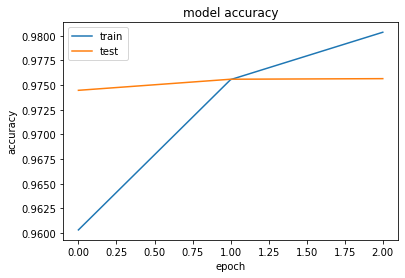

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("finetune_acc.pdf")
plt.show()

Summarize history for loss

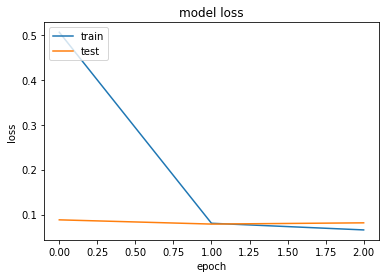

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("finetune_loss.pdf")
plt.show()

## Step 7: Testing the model

In [0]:
y_pred = model.predict([test_pep, test_hla])

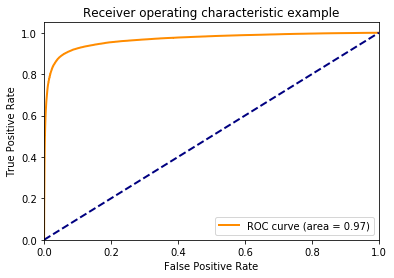

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 2
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(test_lab, y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig("ROC.pdf")
plt.show()

In [0]:
import json
json.dump(model.to_json(), open("model.json", "w"))

This notebook was guided by https://towardsdatascience.com/fine-tuning-bert-with-keras-and-tf-module-ed24ea91cff2